In [29]:
from cerebus import cbpy
import numpy as np
from time import sleep
import threading
from collections import deque
import serial
import pyaudio
import time
import tensorflow as tf

CBPY_BUF_LEN = 2000
DATA_BUF_LEN = 5000
buf = [None]*32
for ch in range(32):
    buf[ch] = deque([])

In [32]:
res, con_info = cbpy.open(parameter=cbpy.defaultConParams())
res, reset = cbpy.trial_config(
    reset=True,
    buffer_parameter={'continuous_length':CBPY_BUF_LEN},
    range_parameter={},
    noevent=1,
    nocontinuous=0,
    nocomment=1
)

try:
    while True:
        result, data, t_0 = cbpy.trial_continuous(reset=True)

        if len(data) > 0:
            break
            # print(f'len_data{len(data)}')
            # print(data[0][1].shape)
            print(data[:][1])
            n_tmp = len(data[0][1])
            len_tmp = len(buf[0])
            if n_tmp+len_tmp <= DATA_BUF_LEN:
                for ch in range(32):
                    for j in range(n_tmp):
                        buf[ch].append(data[ch][1][j])
            else:
                for ch in range(32):
                    for k in range(n_tmp+len_tmp-DATA_BUF_LEN):
                        buf[ch].popleft()
                    for l in range(n_tmp):
                        buf[ch].append(data[ch][1][l])
except KeyboardInterrupt:
    cbpy.close()

In [38]:
data[:]

[2,
 array([-32, -14,   8,  21,  27,  39,  56,  66,  76,  93,  97, 102, 117,
        131, 133, 135, 124,  93,  77,  78,  70,  53,  42,  40,  41,  45,
         43,  26,   7,  -8, -13], dtype=int16)]

In [40]:
from termcolor import cprint

def record_buf(buf, CBPY_BUF_LEN=2000, DATA_BUF_LEN=5000):
    res, con_info = cbpy.open(parameter=cbpy.defaultConParams())
    res, reset = cbpy.trial_config(
        reset=True,
        buffer_parameter={'continuous_length':CBPY_BUF_LEN},
        range_parameter={},
        noevent=1,
        nocontinuous=0,
        nocomment=1
    )
    n_channels = len(buf)

    try:
        while True:
            result, data, t_0 = cbpy.trial_continuous(reset=True)

            if len(data) > 0:
                # cprint(f'len_data{len(data)}', 'cyan')
                # cprint(data[0][1].shape, 'cyan')
                n_tmp = len(data[0][1])
                len_tmp = len(buf[0])
                if n_tmp+len_tmp <= DATA_BUF_LEN:
                    for ch in range(n_channels):
                        for j in range(n_tmp):
                            buf[ch].append(data[ch][1][j])
                else:
                    for ch in range(n_channels):
                        for k in range(n_tmp+len_tmp-DATA_BUF_LEN):
                            buf[ch].popleft()
                        for l in range(n_tmp):
                            buf[ch].append(data[ch][1][l])
    except KeyboardInterrupt:
        cbpy.close()


In [41]:
n_lfp = 32
n_analogin = 3
buf = [None]*(n_lfp+n_analogin)
for ch in range(len(buf)):
    buf[ch] = deque([])
record_buf(buf)

In [50]:
from multiprocessing import Process
import numpy as np

n_lfp = 32
n_analogin = 3
DATA_BUF_LEN = 5000
buf = np.zeros((n_lfp+n_analogin, DATA_BUF_LEN))
buf[:] = np.nan
def record_buf(buf, CBPY_BUF_LEN=2000, DATA_BUF_LEN=5000):
    res, con_info = cbpy.open(parameter=cbpy.defaultConParams())
    res, reset = cbpy.trial_config(
        reset=True,
        buffer_parameter={'continuous_length':CBPY_BUF_LEN},
        range_parameter={},
        noevent=1,
        nocontinuous=0,
        nocomment=1
    )
    ch_indices = list(np.arange(len(buf)))

    try:
        while True:
            result, data, t_0 = cbpy.trial_continuous(reset=True)

            if len(data) > 0:
                n_tmp = len(data[0][1])
                buf[:,:-n_tmp] = buf[:,n_tmp:]
                buf[:,-n_tmp:] = list(map(lambda ch:data[ch][1], ch_indices)) 
    except KeyboardInterrupt:
        cbpy.close()


In [51]:
record_buf(buf, CBPY_BUF_LEN=2000, DATA_BUF_LEN=5000)

In [52]:
lfp = np.array(buf)

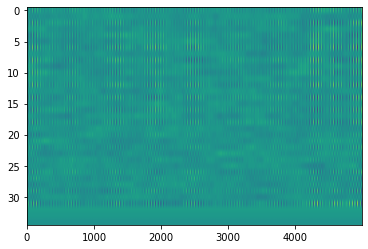

In [56]:
from matplotlib import pyplot as plt
plt.imshow(buf, aspect='auto')

In [59]:
t_0

29890269

In [5]:
from cerebus import cbpy
import threading
from multiprocessing import cpu_count, Process, Event
from mne.filter import filter_data, notch_filter
import mne
from scipy import signal
from scipy.stats import zscore
import numpy as np
import serial
import yaml
from attrdict import AttrDict
import traceback
import time
from termcolor import cprint
mne.set_log_level("CRITICAL")

n_jobs = cpu_count() // 2

def event_detector(
    args,
    buf: np.ndarray,
    ser: serial.Serial,
    stop_event: Event,
    prepare_event: Event,
) -> None:
    try: 
        while not stop_event.is_set():
            if prepare_event.is_set():
                lfp = np.array(buf[:args.n_lfp])
                event_score = preproc(args, lfp)
                if event_score > args.threshold:
                    ser.write(b'a')
                    cprint(f'event detected: {event_score}', 'cyan')
    except Exception as e:
        cprint(traceback.format_exc(), "red")

def preproc(
    args,
    lfp: np.ndarray,
    target_channel: np.ndarray = np.arange(32),
    target_window: int = 600
) -> float:
    # lfp = notch_filter(lfp, Fs, np.arange(notch_freq, Fs//2, notch_freq), verbose=False, n_jobs=n_jobs)
    lfp_bp = filter_data(lfp[target_channel,:], args.Fs, args.l_freq, args.h_freq, n_jobs=n_jobs) # bandpass (highpass) filter
    lfp_env = np.abs(signal.hilbert(lfp_bp)) # envelope
    """FIX ME: 
    z-score should be calculated in incremental manner with enough window (e.g. 10 sec)"""
    # lfp_env = (lfp_env - avg) / sd # z-score
    lfp_env = zscore(lfp_env, axis=1) # z-score
    cprint(lfp_env.shape, 'cyan')
    return np.mean(lfp_env[:, -target_window:])

def record_buf(
    buf: np.ndarray, 
    prepare_event: Event, 
    stop_event: Event,
    CBPY_BUF_LEN: int = 2000, 
) -> None:
    res, con_info = cbpy.open(parameter=cbpy.defaultConParams())
    res, reset = cbpy.trial_config(
        reset=True,
        buffer_parameter={'continuous_length':CBPY_BUF_LEN},
        range_parameter={},
        noevent=1,
        nocontinuous=0,
        nocomment=1
    )
    ch_indices = list(np.arange(len(buf)))

    try:
        while not stop_event.is_set():
            result, data, t_0 = cbpy.trial_continuous(reset=True)

            if len(data) > 0:
                n_tmp = len(data[0][1])
                buf[:,:-n_tmp] = buf[:,n_tmp:]
                buf[:,-n_tmp:] = list(map(lambda ch:data[ch][1], ch_indices)) 
            if not prepare_event.is_set():
                if np.sum(np.isnan(buf)) == 0:
                    prepare_event.set()
    except KeyboardInterrupt:
        cbpy.close()
    except Exception as e:
        cprint(traceback.format_exc(), "red")

def run() -> None:
    with open('./config.yaml', 'r') as yml:
        config = yaml.safe_load(yml)
    args = AttrDict(config)
    buf = np.zeros((args.n_lfp+args.n_analogin, args.DATA_BUF_LEN))
    buf[:] = np.nan
    ser = serial.Serial(f'COM{args.serial_port}', args.srate)
    stop_event = Event()
    prepare_event = Event()

    processes = []
    # processes.append(
    #     Process(
    #         target=record_buf,
    #         args=(buf, prepare_event, stop_event, args.CBPY_BUF_LEN, ),
    #     )
    # )
    # processes.append(
    #     Process(
    #         target=event_detector,
    #         args=(args, buf, ser, stop_event, prepare_event, ),
    #     )  
    # )

    threads = []
    threads.append(
        threading.Thread(
            target=record_buf,
            args=(buf, prepare_event, stop_event, args.CBPY_BUF_LEN, ),
        )
    )
    threads.append(
        threading.Thread(
            target=event_detector,
            args=(args, buf, ser, stop_event, prepare_event, ),
        )
    )

    for p in processes:
        p.start()
    for t in threads:
        t.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        stop_event.set()
        ser.close()
        for p in processes:
            p.join()
        for t in threads:
            t.join()
            
if __name__ == '__main__':
    run()


(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
(32, 5000)
